## CoNLL-2003 Example for Text Extensions for Pandas
### Part 4

If you are unfamiliar with the basics of Text Extensions for Pandas, we recommend you 
start with Part 1 of this example.

### Introduction

At the end of part 3 of the demo, we've shown that we can train multiple synthetic models with different levels of deliberate imprecision. We used the ensemble of models to pinpoint incorrect labels in the test set, using 
the same methods that we employed in [`CoNLL_2.ipynb`](./CoNLL_2.ipynb).

Now we need to pinpoint incorrect labels across the entire data set, including train, development, and test sets.



# Libraries and constants

In [1]:
# Libraries
import numpy as np
import pandas as pd
import os
import sys
import time
import torch
import transformers
from typing import *
import sklearn.model_selection
import sklearn.pipeline
import matplotlib.pyplot as plt

# And of course we need the text_extensions_for_pandas library itself.
PROJECT_ROOT = "../.."
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("corpus"):
        raise e
    if PROJECT_ROOT not in sys.path:
        sys.path.insert(0, PROJECT_ROOT)
    import text_extensions_for_pandas as tp

# Code shared among notebooks is kept in util.py, in this directory.
import util

# BERT Configuration
# Keep this in sync with `CoNLL_3.ipynb`.
#bert_model_name = "bert-base-uncased"
#bert_model_name = "bert-large-uncased"
bert_model_name = "dslim/bert-base-NER"
tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name, 
                                                           add_special_tokens=True)
bert = transformers.BertModel.from_pretrained(bert_model_name)

# If False, use cached values, provided those values are present on disk
_REGENERATE_EMBEDDINGS = False
_REGENERATE_MODELS = False

# Number of dimensions that we reduce the BERT embeddings down to when
# training reduced-quality models.
#_REDUCED_DIMS = [8, 16, 32, 64, 128, 256]
_REDUCED_DIMS = [32, 64, 128, 256]

# How many models we train at each level of dimensionality reduction
_MODELS_AT_DIM = [4] * len(_REDUCED_DIMS)

# Consistent set of random seeds to use when generating dimension-reduced
# models. Index is [index into _REDUCED_DIMS, model number], and there are
# lots of extra entries so we don't need to resize this matrix.
from numpy.random import default_rng
_MASTER_SEED = 42
rng = default_rng(_MASTER_SEED)
_MODEL_RANDOM_SEEDS = rng.integers(0, 1e6, size=(8, 8))

# Create a Pandas categorical type for consistent encoding of categories
# across all documents.
_ENTITY_TYPES = ["LOC", "MISC", "ORG", "PER"]
token_class_dtype, int_to_label, label_to_int = tp.io.conll.make_iob_tag_categories(_ENTITY_TYPES)

# Parameters for splitting the corpus into folds
_KFOLD_RANDOM_SEED = _MASTER_SEED
_KFOLD_NUM_FOLDS = 10


# Read inputs

Read in the corpus, retokenize it with the BERT tokenizer, add BERT embeddings, and convert
to a single dataframe.

In [2]:
# Download and cache the data set.
# NOTE: This data set is licensed for research use only. Be sure to adhere
#  to the terms of the license when using this data set!
data_set_info = tp.io.conll.maybe_download_conll_data("outputs")
data_set_info

{'train': 'outputs/eng.train',
 'dev': 'outputs/eng.testa',
 'test': 'outputs/eng.testb'}

In [3]:
# The raw dataset in its original tokenization
corpus_raw = {}
for fold_name, file_name in data_set_info.items():
    df_list = tp.io.conll.conll_2003_to_dataframes(file_name, 
                                          ["pos", "phrase", "ent"],
                                          [False, True, True])
    corpus_raw[fold_name] = [
        df.drop(columns=["pos", "phrase_iob", "phrase_type"])
        for df in df_list
    ]

In [4]:
# Retokenize with the BERT tokenizer
bert_data = {
    key: tp.jupyter.run_with_progress_bar(
        len(val), 
        lambda i: tp.io.bert.conll_to_bert(val[i], tokenizer, bert, token_class_dtype,
                                           compute_embeddings=_REGENERATE_EMBEDDINGS))
    for key, val in corpus_raw.items()
}

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=946, style=ProgressStyle(desc…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=216, style=ProgressStyle(desc…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

In [5]:
# Create a single dataframe of annotated tokens for the entire corpus
if _REGENERATE_EMBEDDINGS:
    corpus_df = tp.combine_folds(bert_data)
    # We can't currently serialize span columns that cover multiple documents (see issue 73),
    # so the Feather file won't contain them. Drop these columns for consistency when
    # we regenerate the embeddings here.
    cols_to_drop = [c for c in corpus_df.columns if "span" in c]
    corpus_df.drop(columns=cols_to_drop, inplace=True)
else:
    # Use embeddings computed in CoNLL_3.ipynb
    _EMBEDDINGS_FILE = "outputs/corpus.feather"
    if not os.path.exists(_EMBEDDINGS_FILE):
        raise ValueError(f"Precomputed embeddings not found at {_EMBEDDINGS_FILE}. "
                         f"Please rerun CoNLL_3.ipynb to regenerate this file, or "
                         f"set _REGENERATE_EMBEDDINGS to True in the previous cell.")
    corpus_df = pd.read_feather("outputs/corpus.feather")

corpus_df.head()

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,101,0,1,True,O,<NA>,O,0,[-9.85051990e-02 -4.05019194e-01 7.42888331e-0...
1,train,0,1,118,0,1,False,O,<NA>,O,0,[-5.70211187e-02 -4.81120855e-01 9.89867926e-0...
2,train,0,2,141,0,1,False,O,<NA>,O,0,[-4.82420549e-02 -2.53299713e-01 1.16719234e+0...
3,train,0,3,9244,0,1,False,O,<NA>,O,0,[-2.66829878e-01 -3.10087502e-01 1.00747299e+0...
4,train,0,4,9272,0,1,False,O,<NA>,O,0,[-0.22296906 -0.21308506 0.93310195 -0.2613598...


# Prepare folds for a 10-fold cross-validation

We divide the documents of the corpus into 10 random samples.

In [6]:
# IDs for each of the keys
doc_keys = corpus_df[["fold", "doc_num"]].drop_duplicates().reset_index(drop=True)
doc_keys

,fold,doc_num
0,train,0
1,train,1
2,train,2
3,train,3
4,train,4
...,...,...
1388,test,226
1389,test,227
1390,test,228
1391,test,229


In [7]:
# We want to split the documents randomly into _NUM_FOLDS sets, then
# for each stage of cross-validation train a model on the union of
# (_NUM_FOLDS - 1) of them while testing on the remaining fold.
# sklearn.model_selection doesn't implement this approach directly,
# but we can piece it together with some help from Numpy.
#from numpy.random import default_rng
rng = np.random.default_rng(seed=_KFOLD_RANDOM_SEED)
iloc_order = rng.permutation(len(doc_keys.index))
kf = sklearn.model_selection.KFold(n_splits=_KFOLD_NUM_FOLDS)

train_keys = []
test_keys = []
for train_ix, test_ix in kf.split(iloc_order):
    # sklearn.model_selection.KFold gives us a partitioning of the
    # numbers from 0 to len(iloc_order). Use that partitioning to 
    # choose elements from iloc_order, then use those elements to 
    # index into doc_keys.
    train_iloc = iloc_order[train_ix]
    test_iloc = iloc_order[test_ix]
    train_keys.append(doc_keys.iloc[train_iloc])
    test_keys.append(doc_keys.iloc[test_iloc])

train_keys[1].head(10)

,fold,doc_num
146,train,146
1164,test,2
483,train,483
1190,test,28
20,train,20
237,train,237
86,train,86
408,train,408
1252,test,90
1213,test,51


# Dry run: Train and evaluate models on the first fold

Train models on the first of our 10 folds and manually examine some of the 
model outputs.

In [8]:
# Gather the training set together by joining our list of documents
# with the entire corpus on the composite key <fold, doc_num>
train_inputs_df = corpus_df.merge(train_keys[0])
train_inputs_df

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,0,0,101,0,1,True,O,<NA>,O,0,[-9.85051990e-02 -4.05019194e-01 7.42888331e-0...
1,train,0,1,118,0,1,False,O,<NA>,O,0,[-5.70211187e-02 -4.81120855e-01 9.89867926e-0...
2,train,0,2,141,0,1,False,O,<NA>,O,0,[-4.82420549e-02 -2.53299713e-01 1.16719234e+0...
3,train,0,3,9244,0,1,False,O,<NA>,O,0,[-2.66829878e-01 -3.10087502e-01 1.00747299e+0...
4,train,0,4,9272,0,1,False,O,<NA>,O,0,[-0.22296906 -0.21308506 0.93310195 -0.2613598...
...,...,...,...,...,...,...,...,...,...,...,...,...
371472,test,230,314,1711,0,1,False,O,<NA>,O,0,[-2.81727146e-02 -8.06238130e-02 9.80489016e-0...
371473,test,230,315,117,0,1,False,O,<NA>,O,0,[ 1.18174128e-01 -7.00848922e-02 8.65484536e-0...
371474,test,230,316,5545,0,1,False,B,PER,B-PER,4,[-3.56894433e-01 3.14004809e-01 1.57385373e+0...
371475,test,230,317,119,0,1,False,O,<NA>,O,0,[-1.89571261e-01 -2.45811775e-01 6.62574053e-0...


In [9]:
# Repeat the same process for the test set
test_inputs_df = corpus_df.merge(test_keys[0])
test_inputs_df

,fold,doc_num,token_id,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,train,12,0,101,0,1,True,O,<NA>,O,0,[-1.01977840e-01 -4.24424976e-01 8.44017029e-0...
1,train,12,1,118,0,1,False,O,<NA>,O,0,[-9.12464336e-02 -4.77107286e-01 1.12029243e+0...
2,train,12,2,141,0,1,False,O,<NA>,O,0,[-1.69527888e-01 -2.70634979e-01 1.20956707e+0...
3,train,12,3,9244,0,1,False,O,<NA>,O,0,[-2.76482105e-01 -3.67584974e-01 1.09202480e+0...
4,train,12,4,9272,0,1,False,O,<NA>,O,0,[-2.40506291e-01 -2.42474988e-01 1.07511592e+0...
...,...,...,...,...,...,...,...,...,...,...,...,...
45059,test,225,75,2147,0,1,False,O,<NA>,O,0,[-9.62141156e-02 -4.80169058e-01 5.10937452e-0...
45060,test,225,76,1113,0,1,False,O,<NA>,O,0,[-8.58628750e-02 -2.34172851e-01 8.32927525e-0...
45061,test,225,77,4306,0,1,False,O,<NA>,O,0,[-1.22384112e-02 -4.28266734e-01 6.19483531e-0...
45062,test,225,78,119,0,1,False,O,<NA>,O,0,[-4.29562032e-02 -3.63154620e-01 6.60202920e-0...


## Train an ensemble of models

In [10]:
import importlib
util = importlib.reload(util)
import sklearn.linear_model

def train_models(train_df: pd.DataFrame) \
        -> Dict[str, sklearn.base.BaseEstimator]:
    """
    Train an ensemble of models with different levels of noise.
    
    :param train_df: DataFrame of labeled training documents, with one
     row per token. Must contain the columns "embedding" (precomputed 
     BERT embeddings) and "token_class_id" (integer ID of token type)
     
    :returns: A mapping from mnemonic model name to trained model
    """
    X = train_df["embedding"].values
    Y = train_df["token_class_id"]
    models = {}  # Type: Dict[str, sklearn.base.BaseEstimator]

    
    for i in range(len(_REDUCED_DIMS)):
        num_dims = _REDUCED_DIMS[i]
        num_models = _MODELS_AT_DIM[i]
        for j in range(num_models):
            model_name = f"{num_dims}_{j + 1}"
            seed = _MODEL_RANDOM_SEEDS[i, j]
            print(f"Training model '{model_name}' (#{j + 1} "
                  f"at {num_dims} dimensions) with seed {seed}")
            models[model_name] = util.train_reduced_model(X, Y, num_dims, seed)
    
    print(f"Training model using all of "
          f"{X._tensor.shape[1]}-dimension embeddings.")
    models[f"{X._tensor.shape[1]}_1"] = (
        sklearn.linear_model.LogisticRegression(
            multi_class="multinomial",
            verbose=10,
            max_iter=10000
        )
        .fit(X, Y)
    )
    return models

def maybe_train_models(train_df: pd.DataFrame, fold_num: int):
    import pickle
    _CACHED_MODELS_FILE = f"outputs/fold_{fold_num}_models.pickle"
    if _REGENERATE_MODELS or not os.path.exists(_CACHED_MODELS_FILE):
        m = train_models(train_df)
        print(f"Trained {len(m)} models.")
        with open(_CACHED_MODELS_FILE, "wb") as f:
            pickle.dump(m, f)
    else:
        # Use a cached model when using cached embeddings
        with open(_CACHED_MODELS_FILE, "rb") as f:
            m = pickle.load(f)
            print(f"Loaded {len(m)} models from {_CACHED_MODELS_FILE}.")
    return m

models = maybe_train_models(train_inputs_df, 0)
print(f"Model names after loading or training: {', '.join(models.keys())}")

Loaded 17 models from outputs/fold_0_models.pickle.
Model names after loading or training: 32_1, 32_2, 32_3, 32_4, 64_1, 64_2, 64_3, 64_4, 128_1, 128_2, 128_3, 128_4, 256_1, 256_2, 256_3, 256_4, 768_1


In [11]:
# Uncomment this code if you need to have the cells that follow ignore
# some of the models saved to disk.
# _MODEL_SIZES_TO_KEEP = [32, 64, 128, 256]
# _RUNS_TO_KEEP = [4] * len(_MODEL_SIZES_TO_KEEP)
# _OTHER_MODELS_TO_KEEP = ["768_1"]

# to_keep = _OTHER_MODELS_TO_KEEP.copy()
# for size in _MODEL_SIZES_TO_KEEP:
#     for num_runs in _RUNS_TO_KEEP:
#         for i in range(num_runs):
#             to_keep.append(f"{size}_{i+1}")

# models = {k: v for k, v in models.items() if k in to_keep}

# print(f"Model names after filtering: {', '.join(models.keys())}")

## Evaluate the models on this fold's test set

In [12]:
def eval_models(models: Dict[str, sklearn.base.BaseEstimator],
                test_df: pd.DataFrame):
    """
    Bulk-evaluate an ensemble of models generated by :func:`train_models`.
    
    :param models: Output of :func:`train_models`
    :param test_df:  DataFrame of labeled test documents, with one
     row per token. Must contain the columns "embedding" (precomputed 
     BERT embeddings) and "token_class_id" (integer ID of token type)
    
    :returns: A dictionary from model name to results of 
     :func:`util.analyze_model`
    """
    todo = [(name, model) for name, model in models.items()]
    results = tp.jupyter.run_with_progress_bar(
        len(todo),
        lambda i: util.analyze_model(test_df, int_to_label, todo[i][1], 
                                     bert_data, corpus_raw, expand_matches=True),
        "model"
    )
    return {t[0]: result for t, result in zip(todo, results)}

evals = eval_models(models, test_inputs_df)

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

In [13]:
# Summarize how each of the models does on the test set.
def make_summary_df(evals_df: pd.DataFrame) -> pd.DataFrame:
    global_scores = [r["global_scores"] for r in evals_df.values()]
    return pd.DataFrame({
        "name": list(evals_df.keys()),
        "dims": [n.split("_")[0] for n in evals_df.keys()],
        "num_true_positives": [r["num_true_positives"] for r in global_scores],
        "num_entities": [r["num_entities"] for r in global_scores],
        "num_extracted": [r["num_extracted"] for r in global_scores],
        "precision": [r["precision"] for r in global_scores],
        "recall": [r["recall"] for r in global_scores],
        "F1": [r["F1"] for r in global_scores]
    })

summary_df = make_summary_df(evals)

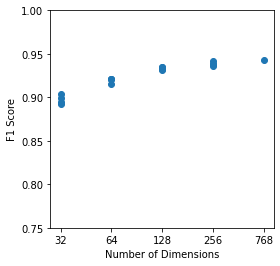

In [14]:
# Plot the tradeoff between dimensionality and F1 score
x = summary_df["dims"]
y = summary_df["F1"]

plt.figure(figsize=(4,4))
plt.scatter(x, y)
#plt.yscale("log")
#plt.xscale("log")
plt.ylim([0.75, 1.0])
plt.xlabel("Number of Dimensions")
plt.ylabel("F1 Score")

# Also dump the raw data to a local file.
pd.DataFrame({"num_dims": x, "f1_score": y}).to_csv("outputs/dims_vs_f1_score_xval.csv",
                                                    index=False)

plt.show()

## Aggregate the model results and compare with the gold standard

In [15]:
full_results = util.merge_model_results(evals)
full_results

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=140, style=ProgressStyle(desc…

,doc_num,fold,doc_offset,span,ent_type,gold,32_1,32_2,32_3,32_4,...,128_1,128_2,128_3,128_4,256_1,256_2,256_3,256_4,768_1,num_models
0,0,train,12,"[11, 16): 'Saudi'",MISC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
1,0,train,12,"[59, 65): 'MANAMA'",LOC,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,17
2,0,train,12,"[86, 91): 'Saudi'",MISC,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,14
3,0,train,12,"[259, 264): 'Saudi'",MISC,True,True,False,False,False,...,True,True,True,True,True,True,True,True,True,13
4,0,train,12,"[403, 412): 'One-month'",MISC,True,True,False,True,True,...,True,True,False,False,False,True,False,False,False,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,139,test,225,"[11, 17): 'BOXING'",LOC,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1
14,139,test,225,"[86, 104): 'German Axel Schulz'",MISC,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,1
15,139,test,225,"[45, 60): 'IBF HEAVYWEIGHT'",MISC,False,False,False,False,False,...,False,True,True,False,False,False,True,False,True,5
16,139,test,225,"[19, 25): 'SCHULZ'",LOC,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1


In [16]:
# Drop Boolean columns for now
results = full_results[["fold", "doc_offset", "span", "ent_type", "gold", "num_models"]]
results

,fold,doc_offset,span,ent_type,gold,num_models
0,train,12,"[11, 16): 'Saudi'",MISC,True,17
1,train,12,"[59, 65): 'MANAMA'",LOC,True,17
2,train,12,"[86, 91): 'Saudi'",MISC,True,14
3,train,12,"[259, 264): 'Saudi'",MISC,True,13
4,train,12,"[403, 412): 'One-month'",MISC,True,9
...,...,...,...,...,...,...
13,test,225,"[11, 17): 'BOXING'",LOC,False,1
14,test,225,"[86, 104): 'German Axel Schulz'",MISC,False,1
15,test,225,"[45, 60): 'IBF HEAVYWEIGHT'",MISC,False,5
16,test,225,"[19, 25): 'SCHULZ'",LOC,False,1


In [17]:
(results[results["gold"] == True][["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
0,115
1,31
2,23
3,20
4,17
5,18
6,23
7,23
8,19


In [18]:
(results[results["gold"] == False][["num_models", "span"]]
 .groupby("num_models").count()
 .rename(columns={"span": "count"}))

,count
num_models,
1,485
2,180
3,91
4,65
5,51
6,26
7,35
8,16
9,20


In [19]:
# Pull out some hard-to-find examples, sorting by document to make labeling easier
hard_to_get = results[results["gold"]].sort_values(["num_models", "fold", "doc_offset"]).head(20)
hard_to_get

,fold,doc_offset,span,ent_type,gold,num_models
0,dev,21,"[25, 39): 'STANDARD LIEGE'",ORG,True,0
2,dev,21,"[86, 90): 'UEFA'",ORG,True,0
18,dev,64,"[2571, 2575): 'AIDS'",MISC,True,0
2,dev,120,"[63, 70): 'English'",MISC,True,0
2,dev,149,"[81, 93): 'Major League'",MISC,True,0
19,dev,182,"[662, 670): 'division'",MISC,True,0
46,dev,182,"[2173, 2177): 'Ruch'",ORG,True,0
6,dev,203,"[879, 881): '90'",LOC,True,0
5,dev,214,"[187, 202): 'Michael Collins'",MISC,True,0
7,dev,214,"[285, 305): 'Venice Film Festival'",MISC,True,0


### TODO: Relabel the above 20 examples with a Markdown table (copy from CSV)


In [20]:
# Hardest results not in the gold standard for models to avoid
hard_to_avoid = results[~results["gold"]].sort_values(["num_models", "fold", "doc_offset"], ascending=[False, True, True]).head(20)
hard_to_avoid

,fold,doc_offset,span,ent_type,gold,num_models
35,dev,149,"[81, 102): 'Major League Baseball'",MISC,False,17
51,dev,214,"[187, 202): 'Michael Collins'",PER,False,17
48,test,23,"[94, 116): 'National Hockey League'",MISC,False,17
44,test,25,"[823, 835): 'Philadelphia'",ORG,False,17
45,test,25,"[856, 864): 'NFC East'",MISC,False,17
26,test,41,"[674, 688): 'Sporting Gijon'",ORG,False,17
6,test,114,"[51, 61): 'sales-USDA'",ORG,False,17
13,test,118,"[535, 550): 'mid-Mississippi'",LOC,False,17
14,test,118,"[776, 791): 'mid-Mississippi'",LOC,False,17
51,test,178,"[1787, 1800): 'Uruguay Round'",MISC,False,17


### TODO: Relabel the above 20 examples (copy from CSV)


# Remainder of Experiment

For each of the 10 folds, train a model on the fold's training set and run
analysis on the fold's test set.

In [21]:
def handle_fold(fold_ix: int) -> Dict[str, Any]:
    """
    The per-fold processing of the previous section's cells, collapsed into 
    a single function.
    
    :param fold_ix: 0-based index of fold
    
    :returns: a dictionary that maps data structure name to data structure
    """
    # To avoid accidentally picking up leftover data from a previous cell,
    # local to this function are named with a leading underscore
    _train_inputs_df = corpus_df.merge(train_keys[fold_ix])
    _test_inputs_df = corpus_df.merge(test_keys[fold_ix])
    _models = maybe_train_models(_train_inputs_df, fold_ix)
    _evals = eval_models(_models, _test_inputs_df)
    _summary_df = make_summary_df(_evals)
    _full_results = util.merge_model_results(_evals)
    _results = _full_results[["fold", "doc_offset", "span", 
                              "ent_type", "gold", "num_models"]]
    return {
        "models": _models,
        "summary_df": _summary_df,
        "full_results": _full_results,
        "results": _results
    }

# Start with the (already computed) results for fold 0
results_by_fold = [
    {
        "models": models,
        "summary_df": summary_df,
        "full_results": full_results,
        "results": results
    }
]

for fold in range(1, _KFOLD_NUM_FOLDS):
    print(f"Starting fold {fold}.")
    results_by_fold.append(handle_fold(fold))
    print(f"Done with fold {fold}.")
    

Starting fold 1.
Loaded 17 models from outputs/fold_1_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=140, style=ProgressStyle(desc…

Done with fold 1.
Starting fold 2.
Loaded 17 models from outputs/fold_2_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=140, style=ProgressStyle(desc…

Done with fold 2.
Starting fold 3.
Loaded 17 models from outputs/fold_3_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 3.
Starting fold 4.
Loaded 17 models from outputs/fold_4_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 4.
Starting fold 5.
Loaded 17 models from outputs/fold_5_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 5.
Starting fold 6.
Loaded 17 models from outputs/fold_6_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 6.
Starting fold 7.
Loaded 17 models from outputs/fold_7_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 7.
Starting fold 8.
Loaded 17 models from outputs/fold_8_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 8.
Starting fold 9.
Loaded 17 models from outputs/fold_9_models.pickle.


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=139, style=ProgressStyle(desc…

Done with fold 9.


In [22]:
# Combine all the results into a single dataframe for the entire corpus
all_results = pd.concat([r["results"] for r in results_by_fold])
all_results

,fold,doc_offset,span,ent_type,gold,num_models
0,train,12,"[11, 16): 'Saudi'",MISC,True,17
1,train,12,"[59, 65): 'MANAMA'",LOC,True,17
2,train,12,"[86, 91): 'Saudi'",MISC,True,14
3,train,12,"[259, 264): 'Saudi'",MISC,True,13
4,train,12,"[403, 412): 'One-month'",MISC,True,9
...,...,...,...,...,...,...
13,test,216,"[20, 29): 'SHEFFIELD'",PER,False,12
14,test,216,"[166, 174): 'Tasmania'",LOC,False,14
15,test,216,"[179, 187): 'Victoria'",LOC,False,14
16,test,216,"[20, 29): 'SHEFFIELD'",LOC,False,1


# Generate CSV files for manual labeling

In [23]:
# Reformat for output
dev_and_test_results = all_results[all_results["fold"].isin(["dev", "test"])]
in_gold_to_write, not_in_gold_to_write = util.csv_prep(dev_and_test_results, "num_models")
in_gold_to_write

,num_models,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
0,0,dev,2,"[25, 30): 'ASHES'",MISC,,,,,,,
3,0,dev,2,"[87, 92): 'Ashes'",MISC,,,,,,,
5,0,dev,2,"[189, 218): 'Test and County Cricket Board'",ORG,,,,,,,
13,0,dev,2,"[614, 634): 'Duke of Norfolk's XI'",ORG,,,,,,,
19,0,dev,2,"[760, 765): 'Leeds'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
21,17,test,230,"[1108, 1115): 'Germany'",LOC,,,,,,,
23,17,test,230,"[1153, 1160): 'England'",LOC,,,,,,,
24,17,test,230,"[1213, 1225): 'Leeds United'",ORG,,,,,,,
25,17,test,230,"[1252, 1259): 'England'",LOC,,,,,,,


In [24]:
not_in_gold_to_write

,num_models,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
51,17,dev,2,"[760, 765): 'Leeds'",LOC,,,,,,,,,
19,17,dev,6,"[262, 267): 'Rotor'",PER,,,,,,,,,
20,17,dev,6,"[399, 404): 'Rotor'",PER,,,,,,,,,
21,17,dev,6,"[567, 572): 'Rotor'",PER,,,,,,,,,
101,17,dev,11,"[1961, 1975): 'Czech Republic'",LOC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,1,test,228,"[40, 43): 'SIX'",ORG,,,,,,,,,
44,1,test,228,"[831, 845): 'Super Peasants'",MISC,,,,,,,,,
49,1,test,228,"[801, 811): 'Doetinchem'",MISC,,,,,,,,,
28,1,test,230,"[19, 29): 'ENGLISHMAN'",LOC,,,,,,,,,


In [25]:
in_gold_to_write.to_csv("outputs/CoNLL_4_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_4_not_in_gold.csv", index=False)

In [26]:
# Repeat for the contents of the original training set
train_results = all_results[all_results["fold"] == "train"]
in_gold_to_write, not_in_gold_to_write = util.csv_prep(train_results, "num_models")
in_gold_to_write

,num_models,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
3,0,train,6,"[121, 137): 'Toronto Dominion'",PER,,,,,,,
4,0,train,24,"[161, 169): 'Africans'",MISC,,,,,,,
7,0,train,24,"[384, 388): 'FLNC'",ORG,,,,,,,
4,0,train,25,"[141, 151): 'mid-Norway'",MISC,,,,,,,
13,0,train,28,"[1133, 1135): 'EU'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
2,17,train,945,"[72, 79): 'English'",MISC,,,,,,,
3,17,train,945,"[119, 127): 'Plymouth'",ORG,,,,,,,
4,17,train,945,"[130, 137): 'Preston'",ORG,,,,,,,
5,17,train,945,"[155, 162): 'Swansea'",ORG,,,,,,,


In [27]:
not_in_gold_to_write

,num_models,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
8,17,train,3,"[0, 10): '-DOCSTART-'",LOC,,,,,,,,,
13,17,train,6,"[121, 137): 'Toronto Dominion'",LOC,,,,,,,,,
66,17,train,29,"[454, 468): 'Phil Mickelson'",PER,,,,,,,,,
67,17,train,29,"[762, 774): 'Mark O'Meara'",PER,,,,,,,,,
49,17,train,36,"[107, 134): 'English County Championship'",MISC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,1,train,943,"[25, 41): 'SAN MARINO GRAND'",LOC,,,,,,,,,
60,1,train,944,"[11, 15): 'GOLF'",LOC,,,,,,,,,
62,1,train,944,"[25, 32): 'MASTERS'",PER,,,,,,,,,
63,1,train,944,"[17, 32): 'BRITISH MASTERS'",LOC,,,,,,,,,


In [28]:
in_gold_to_write.to_csv("outputs/CoNLL_4_train_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_4_train_not_in_gold.csv", index=False)